# Processing/analyzing MS2 lattice movies

I've been working on putting together a computational framework for working with MS2 data collected on the lattice. I had a few purposes: learn to do image processing in Python (and never use Matlab again), be able to do bursting analysis on lattice data (Garcia pipeline apparently doesn't work), and build an orthogonal way to look at MS2 movies generally. On the last point, this isn't to say that I hope to do *better* than the Garcia pipeline — I sincerely doubt that I will, since they have developed their code over years and with considerably more expertise than I have. Rather, there's some value in just having alternate ways to look at data. If two people take their own approaches to analyzing data and come to similar concluisions, that's a stronger endorsement of said conclusions than would a single analysis strategy.

A note on the utility of coding club: Aside from specific bits of python I have picked up, I followed suggestions by Ciera and Marc in doing this. Specifically, I tried to follow Ciera's instinct to push through to the end with dirty/shitty code, and then go back and revise, and I think that helped me go faster and avoid a lot of wasted time. I also tried to follow Marc's resistance to pipelines: I don't think of this as a pipeline into which one pumps data and extracts a result. Rather, I think of it as an analysis strategy or framework which can be used as a standardized pipeline but is also flexible enough to (ideally) be adapted to different types of data or to asking different questions. Time will tell how well this succeeded.

I've written a series of functions that collectively do the following for lattice MS2 data:

1. Load lattice imaging data
2. Segment nuclei from 3D stacks using nuclear label channel (if such exists).
2. Connect segmented nuclei across multiple stacks (time)
3. Detect/segment MS2 spots in a 3D stack and fit with gaussian.
4. Connect detected MS2 spots across time.
5. Integrate signal from ellipsoid volumes around spots.

I developed this code across a series of Jupyter notebooks, organized by task ('Segment-nuclei-singlstack', 'Connect-spot-multiframes', etc.), and organized the final code into a module, __imagep.py__. I tried to write the "finished" code in best-practices Python style, with extensive commenting, docstrings, etc., though I've certainly been lax in some areas. This module contains the code for the above tasks, but also contains some general purpose functions that I hope will be useful for analyzing image data, including code for simple interactive viewers, plotting parameter series, or doing some basic image manipulations (e.g., applying morphological operations to labelmasks).

To start, I load my modules and some standard packages:

In [2]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
from importlib import reload
%matplotlib inline

In [3]:
# Import my packages.
import sys
sys.path.append('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin')
from imagep import (read_tiff_folder, read_tiff_lattice, viewer, viewer, 
                    segment_embryo, labelmask_apply_morphology, zstack_normalize_mean,
                   peak_local_max_nD, gradient_nD, labelmask_filter_objsize, filter_labelmask,
                   object_circularity, stack_bgsub, segment_nuclei3D_5, lattice_segment_nuclei_5,
                   dog_filter, imfill, segMS2_3dstack, dog_filter, qax)
import imagep as imp
import fitting as fit

## 1 - Load data

Next, we have to read the lattice data in. Lattice movies are stored as file series of 3D TIF stacks, with the two channels denoted by *CamA* and *CamB*. __read_tiff_lattice__ will read lattice data into an ndarray of dimensions [c,t,z,x,y]. Subsets of the data can be loaded using the *span* keyword and a tuple, as in *span=(0,4)* to load frames 0-4.

In [247]:
stack = read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20171207_Zldeve_em5_mv2/', span=(0,9))

## 2 - Segment nuclei from 3D stacks

These movies provide several challenges for segmentation/object detection. First, the samples vary considerably in nuclear size, spacing, movement, and labeling strength due to embryo age and the labeled protein (histone vs. Zelda vs. Bicoid...). Second, lattice illumination is much less uniform than confocal data--illumination can vary significantly in lateral (xy) and axial (z) dimensions. Third, the embryo border can produce a strong fluorescence signal that can confound processing (especially thresholding), and the intensity of the boundary signal varies significantly both between samples and within stacks (different z-slices). 

We can see these issues in the example stack, using the interacting __viewer__ function. The higher Z-stacks (numerically lower) have a strong, thick embryo border signal. The border thins and weakens so that near the bottom of the stack it is absent completely from parts of the frame. You can also see the uneven illumination in xy, as the nuclei in the upper left in particular become weaker and fuzzier. This is a result of the lattice sheet itself: it is not an actual sheet, but is instead relatively flat over a certain area. The sheet used in this movie seems to be focused a bit toward the lower part of the image, so that the sheet at the top of the image is thicker, resulting in blurring and less intense illumination in the focal plane.

In [202]:
viewer(stack, 'ctzxy')

interactive(children=(Dropdown(description='Color', index=6, options=('gray_r', 'inferno', 'Reds', 'Greens', '…

Because of these issues, I opted not to take a one-size-fits-all approach to segmenting nuclei from these stacks, but rather tried to find an approach that could be tuned to fit an individual dataset. To this end, I start nuclear segmentation by testing parameters on the 3D stack represented by the first time frame and, once suitable parameters are found, implement 4D segmentation of the entire movie.

To segment nuclei in these stacks, simple smoothing and thresholding approaches are surprisingly effective. In fact, for samples with sparse nuclei (early cycles), this is all you need--3-4 lines of code. Unfortunately, when nuclei become more packed, this approach begins to merge nuclei together. Also, in movies with bright embryo borders, a lot of nuclei end up "touching" the border in one frame and this results in a giant structure with the border joined to a bunch of nuclei. There are many solutions to these problems, and I don't think I've exactly solved them, but I'll describe my segmentation routine *as of today*.

### Background subtraction
First, I wanted to remove the embryo border. I tried a __*TON*__ of things, and many of them work to greater or lesser degrees. The solution I'm using now is based on the observation structures that are present in both the green (e.g. Zelda-GFP) and red (MS2) channels generally represent background fluorescence, including the embryo border. In fact, the MS2 channel should be all background except the MS2 spots themselves. So I start by subtracting a smoothed version of the red channel from the green, which effectively removes the embryo border and other background structures. It also subtracts the MS2 spots, of course (though smoothing helps), so it's important to make sure this is taken care of in subsequent steps.

In [204]:
# Perform background subtraction to remove/suppress embryo border.
bgsub = stack_bgsub(stack)

In [206]:
viewer(bgsub[1],'tzxy')

interactive(children=(Dropdown(description='Color', index=6, options=('gray_r', 'inferno', 'Reds', 'Greens', '…

### Segment a single 3D stack

To segment nuclei in 3D stacks, I use an approach based around the watershed algorithm. Watershed is particularly useful for separating objects that touch each other, which makes it a useful solution for our problem of merging nuclei. You can read all about watershedding via google (prepare to learn what a "catchement basin" is), but I don't find the analogies all that intuitive. I tried pretty hard to think of a good metaphor (I tried muffin tins and ice cube trays) but I gave up and ya'll are just gonna have to google catchement basins. Metaphorically, we're gonna fill each nucleus with water until the water overflows and touches water from other nuclei, at which point the algorithm yells "stop!" and you've got a segmented nucleus.

Functionally, we need to produce two things to give to the watershed function:
1. A transformation of the stack that identifies the edges of nuclei
2. A list of "seed" points that lie within nuclei. 

For nuclear edges, a good option is to use a gradient filter, which acts essentially like a first derivative, mapping the rate of change in signal intensity in the image. Here is a simple gradient filter on the first frame:

In [207]:
# DoG filter on bgsub.
frame0 = bgsub[1,0]
grad=gradient_nD(frame0)
viewer(grad, 'zxy')

interactive(children=(Dropdown(description='Color', index=6, options=('gray_r', 'inferno', 'Reds', 'Greens', '…

This does highlight the nuclear edges, but also picks up a lot of stuff within nuclei. It certainly doesn't turn the nuclei into rings. What we notice in the image is that a lot of small things--Zelda blobs in the nucleus!--are picked up. This makes sense, since those represent changes in signal intensity, which the gradient filter should pick up. What we would like to do is come up with an approach that ignores those small structures and only sees the larger, nucleus-sized structures. We need to turn the nuclei into uniform blobs.

There are a number of ways to do this, and I'm currently using the difference-of-gaussian (DoG) filter. DoG filters essentially act as band-pass filters: you supply an upper and lower frequency, and structures of lower and higher frequency than that get tossed out. It's an excellent way to detect blobs of a desired size. If you find thinking about 'frequency' in image data confusing, playing around with DoG filters for a bit is a useful way to develop an intuitive understanding. Empirically, I found that using sigmas of 10 and 20 pixels gives nice clean nuclear blobs:

In [208]:
# Difference of gaussian filter to make nuclear blobs.
dog = dog_filter(frame0, 10, 20)
viewer(dog, 'zxy')

interactive(children=(Dropdown(description='Color', index=6, options=('gray_r', 'inferno', 'Reds', 'Greens', '…

In [209]:
# Take gradient, handle nan.
grad = gradient_nD(dog)
grad[np.isnan(grad)] = grad[~np.isnan(grad)].max()
viewer(grad, 'zxy')

/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin/imagep.py:351: RuntimeWarning: invalid value encountered in sqrt
  gradient = np.sqrt(sumsq)


interactive(children=(Dropdown(description='Color', index=6, options=('gray_r', 'inferno', 'Reds', 'Greens', '…

This gives us a pretty good set of nuclear edges. Now we need to find seeds within nuclei. For this, I first made a crude nuclear mask using smoothing and thresholding:

In [210]:
from skimage.filters.thresholding import threshold_otsu
# Normalize each Z-slice to mean intensity to account for uneven illumination.
stacknorm = zstack_normalize_mean(frame0)
# Apply gaussian filter.
stack_smooth = ndi.filters.gaussian_filter(stacknorm, sigma=3)
# Threshold, make binary mask, fill.
t = threshold_otsu(stack_smooth)
mask = np.where(stack_smooth >= t, 1, 0)
mask = imfill(mask, (0,0,100))
# Use morphological erosion to remove spurious connections between objects.
mask = ndi.morphology.binary_erosion(mask, structure=np.ones((1, 5, 5)))

In [211]:
viewer(mask,'zxy')

interactive(children=(Dropdown(description='Color', index=6, options=('gray_r', 'inferno', 'Reds', 'Greens', '…

A distance transform of this mask does a good job of creating peaks in the centers of nuclei. In a distance transform, each pixel in the "foreground" (mask value = 1) gets replaced by its distance to the nearest background pixel:

In [212]:
dist = ndi.distance_transform_edt(mask)
viewer(dist,'zxy')

interactive(children=(Dropdown(description='Color', index=6, options=('gray_r', 'inferno', 'Reds', 'Greens', '…

Scikit image has a function to find local maxima, but it seems to only work in 2D. There may be an n-dimensional version, but I didn't find it and wrote my own function, __local_max__, to find pixels that represent their local maximum within a supplied window. Because it's a distance transform, you often get little clusters of max pixels in the centers of nuclei that are all equally distant from background, and we need single pixels for our watershed seeds. I wrote a second function, __peak_local_max_nD__ to wrap __local_max__ and find these clusters and select the single pixel representing the centroid of the cluster to be the seed:

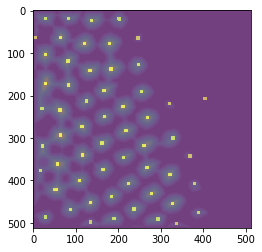

In [213]:
# Find seeds via local max of distance transform.
seeds, _ = peak_local_max_nD(dist, size=(70,50,50))
# Do some dilation so we can see the seeds.
seeds_v = ndi.morphology.binary_dilation(seeds, structure=np.ones((3,8,8)))
# Visualize seeds overlaid with dist on a max project.
plt.imshow(dist.max(axis=0), alpha=0.5);
plt.imshow(255*seeds_v.max(axis=0), alpha=0.5);

This looks terrific. We have seeds in all the nuclei we can see, and a few seeds outside of nuclei. We'll need to keep an eye on these, but it should be relatively easy to deal with them later. Principally, the watershed algorithm will not likely make discrete structures of them (they'll get blended together in a background structure). Anyway, we've got our two components required for watershedding, let's see what we get:

In [214]:
from skimage.segmentation import watershed
ws = watershed(grad, seeds.astype(int))

In [215]:
viewer(ws, 'zxy')

interactive(children=(Dropdown(description='Color', index=6, options=('gray_r', 'inferno', 'Reds', 'Greens', '…

This looks mostly excellent--it seems like we got our nuclei. Of course, there are those giant blobby objects over on the left that watershed spit out. These are easily disposed of with some light object filtering. I wrote functions to filter for object size and circularity, and these blobs get tossed out. The circularity filter can be especially useful for filtering out embryo borders if background subtraction isn't successful or fully effective. I also wrote a function that allows the application of binary morphological processes to labelmasks, which I typically use to slightly dilate (expand) the nuclear masks. The is because the masks sometimes miss a little of the nucleus around the edges, and I would rather bias myself in that direction, since a detected MS2 spot that is just adjacent to the nuclear mask is almost certainly in the nucleus and just narrowly missed by the nuclear segmentation. I put all of this together in a single function, __segment_nuclei3D_5__:

In [216]:
mask = segment_nuclei3D_5(frame0, seed_window=(70,50,50), circularity_min=0.1, size_max=5e5, size_min=0, erosion_length=5, dilation_length=10)

/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin/imagep.py:810: RuntimeWarning: divide by zero encountered in double_scalars
  circularity = 4 * np.pi * area / (perimeter ** 2)


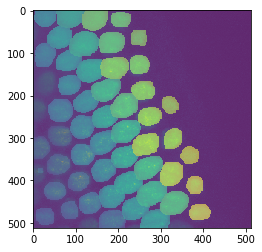

In [217]:
# Plot segmentation over original image.
plt.imshow(frame0.max(axis=0),alpha=0.7)
plt.imshow(mask.max(axis=0), alpha=0.5)

In [219]:
viewer(mask,'zxy')

interactive(children=(Dropdown(description='Color', index=6, options=('gray_r', 'inferno', 'Reds', 'Greens', '…

## 3 - Connect segmented nuclei in time (segment in 4D)

This works really well for single frames (3D stack). To segment a 4D stack, I am currently running this function on successive frames and then using a separate function to connect nuclear labels between frames. I connect by a "reciprocal best hits" criterion, where nucleus x and nucleus y have to be each other's best hits (label in the other frame with the most overlapping pixels) for them to be declared the same.

This works well generally, but it is subject to drop-out—I lose nuclei, and in the current implementation, once a nucleus is "lost" in a frame it is lost for all subesequent frames. I'm actively working on improving this and am currently not sure exactly where the dropout is coming from. Suggestions welcome of course...

The code is in the functions __update_labels__ and its wrapper __segment_nuclei4D__ in *imagep.py*, if you're interested, but I'd consider this still a work in progress at the moment.

## 4 - Detecting MS2 spots (single 3D stacks)

I followed a similar plan as for nuclear segmentation: first segment spots from single 3D stacks, then connect detections from time-series of frames. To detect MS2 spots, I started with a bandpass filter. The DoG really shines here. To demonstrate, let's look at a single 2D slice with some dots:

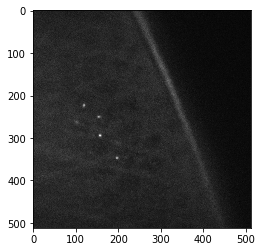

In [220]:
# Load stack.
teststack = read_tiff_lattice(
    '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/20171207_Zldeve_em5_mv2/',
    span=(0,1))
# Select a 2D slice with dots.
red = stack[0,0,56]
# Plot original, unfiltered image:
plt.imshow(red, cmap="gray")

Now let's try a range of parameters for the DoG filter. I fixed the smaller sigma is at 0.5, so the filter will mostly act as a high-pass filter: it's only letting high-frequency information through, and as big sigma increases, it lowers the cutoff and lets more low-frequency information through. I wrote this little wrapper function __plot_ps__ to plot a parameter series quickly:

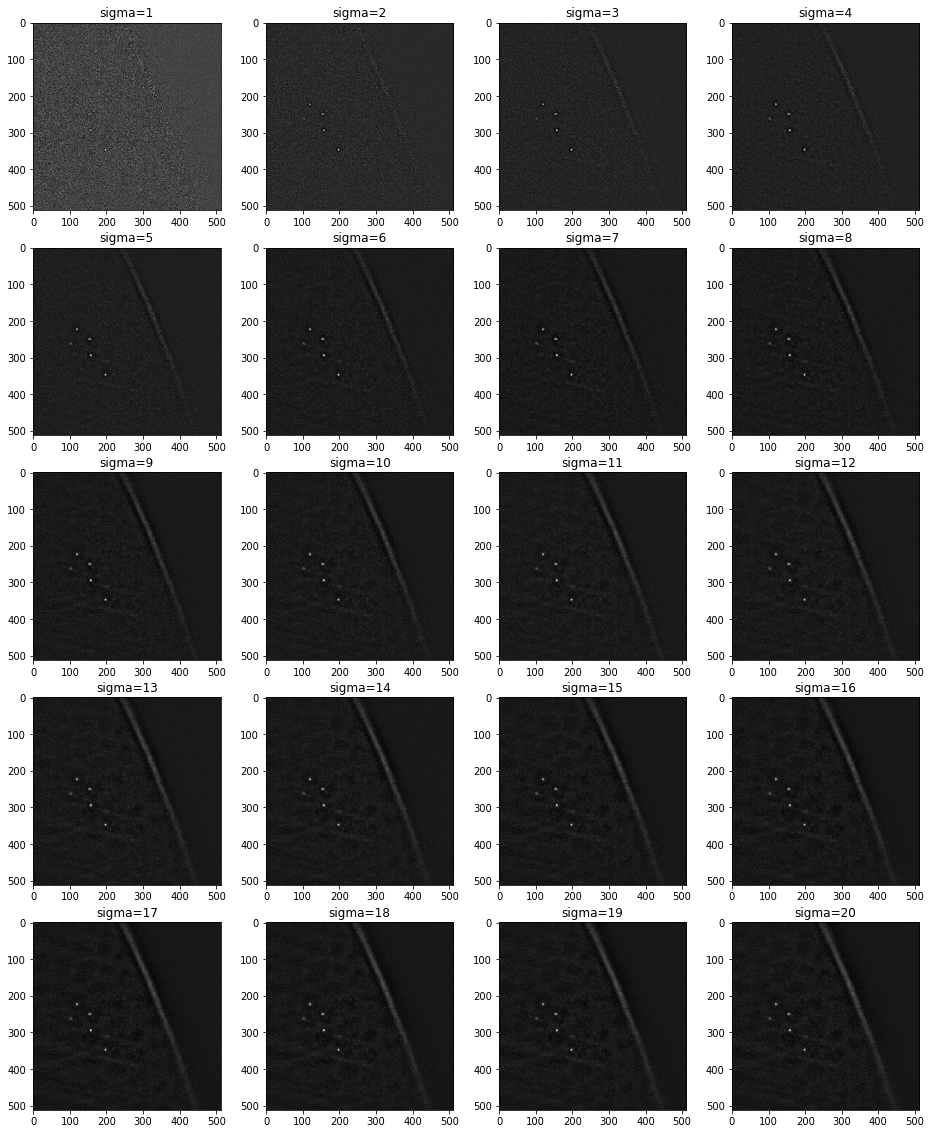

In [221]:
def plotdog(x):
    a = dog_filter(red, 0.5, x)
    plt.title('sigma='+str(x))
    plt.imshow(a, cmap='gray');

imp.plot_ps(plotdog, range(1,21));

The effect is pretty cool. At an extremely high cutoff (sigma=1), even the dots are filtered out. As we move the frequency cutoff (increase sigma) to let lower frequency signal through, we first see the MS2 dots emerge, then gradually the rest of the signal visible in the original image — embryo border, nuclear outlines, lattice shadowing — become visible.

For sigma values in the ~2-6 range, this works great — most of the features in the image are gone and we are left with the MS2 spots and the embryo border signal. From playing around, it doesn't seem like the exact choice of sigma matters. Anything in the 2-4 range works well (and probably others)—I currently use 4 as the default. 

The DoG filter is enough pre-processing to do the job, but I also use a background subtraction with a minimum filter (I just played around and this seemed to do a good job of cleaning the images up without the computational overhead of median filtering). Here's a parameter series testing different sizes for the minimum filter:

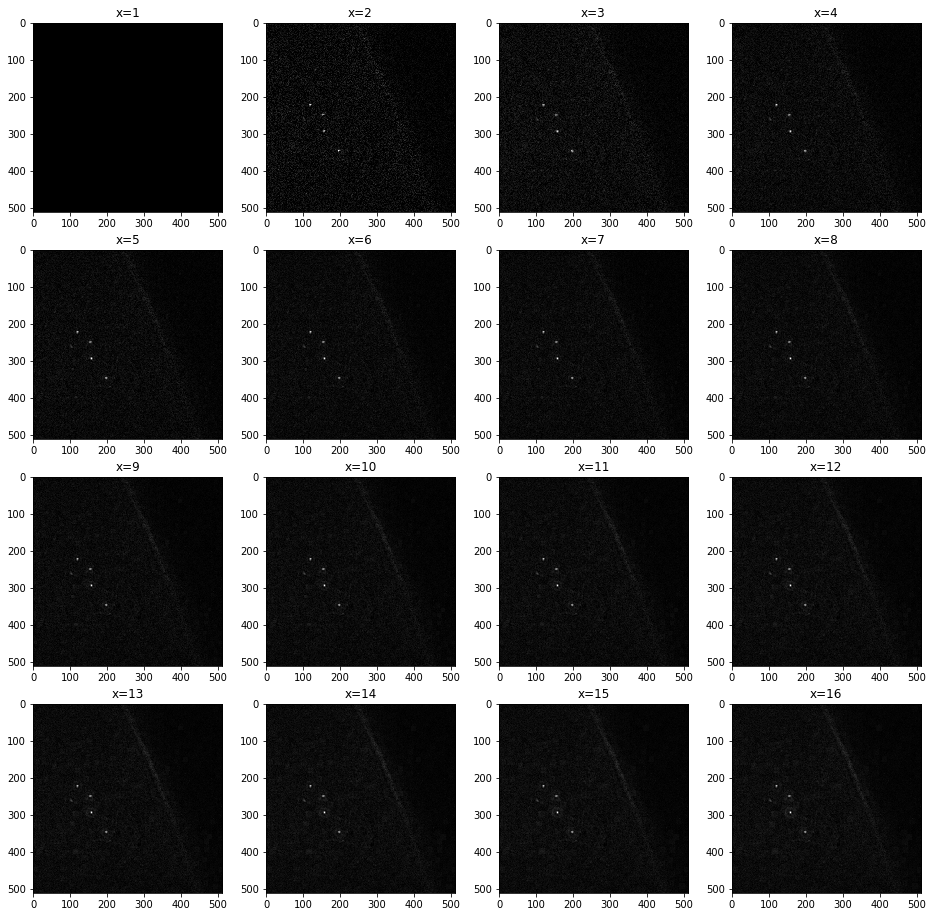

In [222]:
dog = dog_filter(red, 0.5, 4)
def minsplot(x):
    a = ndi.filters.minimum_filter(dog, x)
    b = dog - a.astype(np.int16)
    plt.title('x='+str(x))
    plt.imshow(b, cmap='gray');

#ax=qax(8)
imp.plot_ps(minsplot, range(1,17));

I currently use a radius of 4 for the min filter, with no justification other than visual inspection. Here's a side-by-side of the original image with our filtered image:

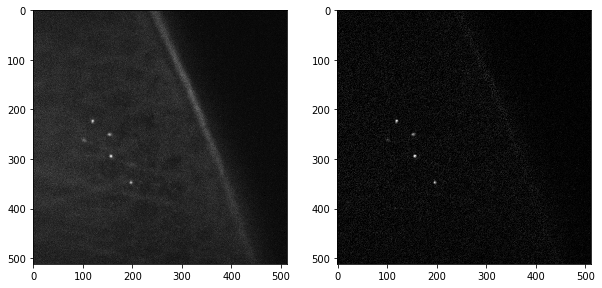

In [223]:
dog_bgs = dog - ndi.filters.minimum_filter(dog, 4).astype(np.int16)    
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(red, cmap="gray");
ax[1].imshow(dog_bgs, cmap="gray");

We've isolated spots above background pretty well — they're clearly the brightest things in the image. These spots can easily be found by detecting local maxima, using the same function I wrote for nuclear segmentation. This function finds the maxima within nucleus-sized boxes (actually 3D rectangles since it's all in 3D). It will clearly find the the MS2 spots, but it will also find maxima in the regions of the image that lack spots. Here the local maxima are shown as gray boxes overlaid on the original image in red:

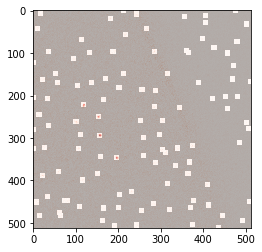

In [137]:
spotmask, peaks = peak_local_max_nD(dog_bgs, size=(50,50))
spotmask = ndi.morphology.binary_dilation(spotmask, structure=np.ones((12,12)))
plt.imshow(dog_bgs, alpha=0.8, cmap="Reds")
plt.imshow(spotmask, alpha=0.3, cmap="gray")

So we need to filter these somehow to decide which are the real spots and which are pointless local maxima. The first criterion is obvious: it has to be in a nucleus. Since we have a nuclear mask already, that's easy enough to implement. In my current implementation I actually do nucleus screening downstream, but it's certainly a useful filter. There are a few properties that real MS2 spots have that distinguish them from background. The obvious ones are size, intensity, and shape — any of these could probably be used to successfully find real spots.

I decided, in a sense to use all three. The next step in the pipeline is to fit a 3D gaussian function to the spots. This fit conveniently gives us information on the size, shape, and intensity of the spot, so I go ahead and just perform a fit on all of the candidate local maxima and use the fit parameters to screen for the real ones.

### A few notes on fitting

What does it mean to "fit a 3D gaussian" to a spot? First, a 3D gaussian is a normal distribution in 3D. For microscopy data, a 3D gaussian would be brightest in the center pixel and then the brightness would decay exponentially in all directions as you move away from the center. I've made a 3d gaussian function in the center of this viewing window:

In [224]:
x, y, z = np.indices(frame0.shape)
# p = (height, center_z, center_x, center_y, width_z, width_x, width_y)
p = (255, 51, 256, 256, 25, 50, 50)
f = fit.gaussian3d(*p)
g = f(x, y, z)
viewer(g, 'zxy')

interactive(children=(Dropdown(description='Color', index=6, options=('gray_r', 'inferno', 'Reds', 'Greens', '…

So we are saying that we think our spots will be modeled reasonably well by a 3D gaussian function. An individual 3d gaussian distribution is characterized by seven parameters: the intensity (sometimes called 'height' in an analogy to a 1D gaussian distribution), the location of the center of the distribution in each dimension (3 parameters), and the width (standard deviation) of the distribution in each dimension. In mathier notation, the 3D gaussian is a function:

3D gaussian = f(height, center_z, center_x, center_y, width_z, width_x, width_y)

So each unique combination of those 7 parameters gives a unique distribution. When we "fit" a gaussian to a spot, all we are saying is "find the combination of these 7 parameters that gives an intensity distribution that most closely matches our real data". 

For a graphical representation, imagine we are playing a game (ok it's the shittiest game in the universe, but it's quarantine and we'll try anything to stay occupied). You have a control panel with 7 knobs controlling the 7 parameters above, and you start with the centered distribution above. Then you get a new picture of a random spot, and you have to adjust the knobs to make them match:

In [225]:
x, y, z = np.indices(frame0.shape)
# p = (height, center_z, center_x, center_y, width_z, width_x, width_y)
p1 = (255, 51, 256, 256, 25, 50, 50)
f1 = fit.gaussian3d(*p1)
g1 = f1(x, y, z)

p2 = (200, 51, 200, 200, 25, 37, 37)
f2 = fit.gaussian3d(*p2)
g2 = f2(x, y, z)
viewer([g1,g2], 'zxy')

interactive(children=(Dropdown(description='Color', index=6, options=('gray_r', 'inferno', 'Reds', 'Greens', '…

You notice that the new spot is off-centered, so you'd probably start by moving the center coordinates until the guy on the left is centered on the one on the right. Then you notice the new spot is dimmer, so you roll down the intensity until they seem equally bright. Then you notice the spot on the right is narrower, so you start dialing down the widths. You fiddle around with the knobs for a while until you've made the spot on the left look as close to the spot on the right, and you're done. That's it: you've fit a gaussian to a spot.

All we are doing is having a computer do the same thing. We define an error function (here: the sum of the squares of the differences in pixel values over the window), and ask the computer to test parameter combinations in an effort to minimize that error function. I use scipy's __optimize__ module for fitting, specifically its __least_squares__ function. This function takes an error function, parameters, and optional bounds for the parameters, and finds parameters that minimize the squared error function. 

In [226]:
def fitgaussian3d(data):
    """Fit a gaussian
    
    Returns (height, z, x, y, width_z, width_x, width_y)
    the gaussian parameters of a 3D distribution found by a least squares 
    fit. Wrote for 3D, but will work for 2D.
    
    Args:
        data: ndarray
            The 3D data to fit in shape [z,x,y]
    Returns:
        opt: OptimizeResult
            opt.x: parameters of the fit: (height, z, x, y, width_z, width_x, width_y)
            opt.success: boolean: whether fit exited successfully
    """
    
    params = moments3d(data)
    # Error function is simple difference between gaussian function and data.
    errorfunction = lambda p: np.ravel(gaussian3d(*p)(*np.indices(data.shape)) -
                                 data)
    opt = optimize.least_squares(errorfunction, params, bounds=([-np.inf,0,0,0,-np.inf,-np.inf,-np.inf],[np.inf,data.shape[0]-1,data.shape[1]-1,data.shape[2]-1,np.inf,np.inf,np.inf]))
    return opt

To fit all the candidate spots, I draw a little box around each of the local max points and feed it to the fitting function. This function returns the fit parameters for each spot and gives each a unique ID. I've packed all this into a function __segMS2_3dstack__. Normally this function filters the spots for "real" MS2 dots, but if I turn all the filters off, it just returns the fit data for each candidate spot:

In [229]:
# Get fit data for all candidate spots.
reload(imp)
fit_data = imp.segMS2_3dstack(stack[0,0], h_thresh_multiplier=0, xy_max_width=np.inf)

# Unpack dictionary into ndarray, useful for parsing.
def dict2ndarray_vstack(data):
    keys = list(data.keys())
    arr = np.array([data[keys[0]]])
    for i in keys[1:]:
        arr = np.vstack((arr, data[i]))
    return arr
    
fitparams = dict2ndarray_vstack(fit_data)

This gives us an array where each row is  different candidate spot, and each row contains the parameters for the fit of that spot. We can look at the distributions of these parameters in different ways:

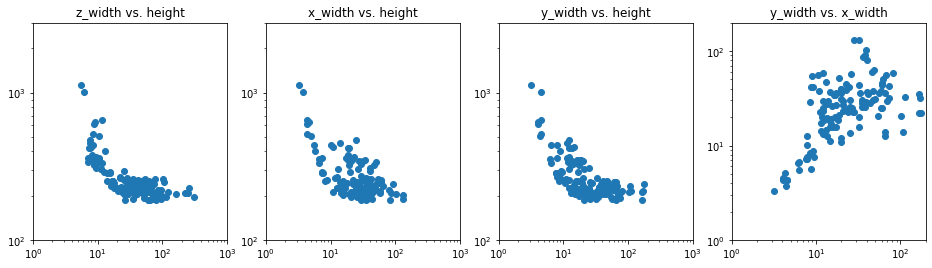

In [230]:
ax=qax(4)
ax[0].scatter(fitparams[:,4],fitparams[:,3])
ax[0].set_xlim((0,100))
ax[0].set_xlim((1, 1000))
ax[0].set_ylim((100,3000))
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('z_width vs. height')
ax[1].scatter(fitparams[:,5],fitparams[:,3])
ax[1].set_xlim((1, 1000))
ax[1].set_ylim((100,3000))
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('x_width vs. height')
ax[2].scatter(fitparams[:,6],fitparams[:,3])
ax[2].set_title('y_width vs. height')
ax[2].set_xlim((1, 1000))
ax[2].set_ylim((100,3000))
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[3].scatter(fitparams[:,6],fitparams[:,5])
ax[3].set_title('y_width vs. x_width')
ax[3].set_xlim((1,200))
ax[3].set_ylim((1,200))
ax[3].set_xscale('log')
ax[3].set_yscale('log')

These aren't the best illustrations, but it turns out that the real spots are best characterized by a combination of having a large height and a narrow width — i.e., they are small and bright as opposed to diffuse and dim. We can also visualize this by trying out filtering with height and width.

In [238]:
# Function to plot overlap of filtered spots (as squares) and original data.
def plot_detections(im, fit_data, min_h, max_w):
    det = np.zeros((im.shape[1], im.shape[2]))
    edgel = 8
    for spot_id in fit_data:
        spot_data = fit_data[spot_id]
        if (spot_data[3] > min_h and spot_data[5] <= max_w):
            xmin = max(0, spot_data[1] - edgel)
            xmax = min(im.shape[1] - 1, spot_data[1] + edgel)
            ymin = max(0, spot_data[2] - edgel)
            ymax = min(im.shape[2] - 1, spot_data[2] + edgel)
            xmin, xmax, ymin, ymax = [int(i) for i in [xmin, xmax, ymin, ymax]]
            det[xmin:xmax, ymin:ymax] = 1
    plt.imshow(det, alpha=0.5, cmap="gray_r")
    plt.imshow(im.max(axis=0), alpha=0.9, cmap="Reds")

Filtering on height alone, this is about the best we can do getting all of our spots:

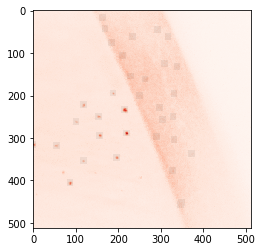

In [239]:
# Filtering on height alone.
plot_detections(stack[0,0], fit_data, 300, np.inf)

Now if we add a filter for width, we get what we want:

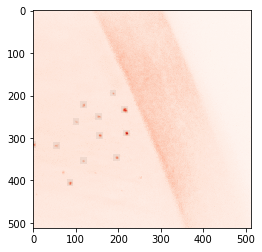

In [240]:
plot_detections(stack[0,0], fit_data, 300, 10)

You see that we missed a spot at around (380, 80). It got excluded because I used too large a size for the local max search — it's too close to its neighboring spot and it lost out because it's dimmer. QC on all these steps is important...

The last filtering step is to include our nuclear segmentation and demand that MS2 spots be found within nuclei. I've currently implemented that into my function that links MS2 spots across frames.

## 5 - Connecting MS2 spots in time

The approach I use for connecting MS2 spots across frames is very straightforward. I run the detection function on the new frame, then I got spot-by-spot in the newly detected spots and attempt to connect them to spots detected in previous frames. To be connected to an existing spot, the new spot must be 1) the closest spot, 2) within a prescribed distance, and 3) contained within the same nucleus. I also allow spots to disappear and return, with a max number of allowable "gap" frames supplied by the user. Connection is done using a function which adds a new frame to existing spot data, __add_ms2_frame__, and the whole thing is wrapped up in a function __ms2_segment_stack__ which takes an image stack (movie) and a nuclear mask and runs the full spot detection-connection on all the frames. The return is a dictionary of spots, with each entry being an ndarray containing data for each frame the spot was detected in, including the spot coordinates and gaussian fit parameters. The following code runs the spot segmentation on 10 frames of the movie, then makes a "viewable" stack that draws boxes around the detections. (also currently using a dummy nuclear mask because I'm tweaking the nuclear segmentation due to some dropout issues on this dataset).

In [242]:
reload(imp)
segMS2_3dstack = imp.segMS2_3dstack
spot_data = imp.ms2_segment_stack(stack, 0, np.ones_like(stack[0]))

1
2
3
4
5
6
7
8
9


In [243]:
def box_spots(stack, channel, spot_data, max_mult=1.3):
    stack = np.copy(stack[channel])
    hival = 1.3 * stack.max()
    
    def drawbox(stack, point, halfwidth_xy, halfwidth_z, linewidth, hival):
        t, z, i, j = point
        z_min = max(0, z - halfwidth_z)
        z_max = min(stack.shape[1], z + halfwidth_z)
        i_min = max(0, i - halfwidth_xy)
        i_max = min(stack.shape[2], i + halfwidth_xy)
        j_min = max(0, j - halfwidth_xy)
        j_max = min(stack.shape[3], j + halfwidth_xy)
        # Draw left line.
        stack[t, :, i_min:i_max, j_min:(j_min + linewidth)] = 0
        stack[t, z_min:z_max, i_min:i_max, j_min:(j_min + linewidth)] = hival     
        # Draw right line.
        stack[t, :, i_min:i_max, (j_max-linewidth):j_max] = 0
        stack[t, z_min:z_max, i_min:i_max, (j_max-linewidth):j_max] = hival
        # Draw top line.
        stack[t, :, i_min:(i_min+linewidth), j_min:j_max] = 0
        stack[t, z_min:z_max, i_min:(i_min+linewidth), j_min:j_max] = hival
        # Draw bottom line.
        stack[t, :, (i_max-linewidth):i_max, j_min:j_max] = 0
        stack[t, z_min:z_max, (i_max-linewidth):i_max, j_min:j_max] = hival

    for spot in spot_data:
        arr = spot_data[spot]
        for row in arr:
            row = row.astype(int)
            point = (row[[0,2,3,4]])
            drawbox(stack, point, 15, 15, 3, hival)
    return stack   

In [246]:
boxes = box_spots(stack, 0, spot_data) 
viewer(boxes.max(axis=1), 'txy')
#viewer(boxes,'tzxy')

interactive(children=(Dropdown(description='Color', index=6, options=('gray_r', 'inferno', 'Reds', 'Greens', '…

So with the current (default) settings, the tracking works pretty well until they start fading in the later frames, when fainter spots drop. I haven't spent much time with this dataset, so I can try tweaking parameters to see if I can clean this up and push the detection thresholds. Anyway, it's a start.

## 6 - Next steps

When this strategy works, I ended up with a movie with segmented nuclei and many detected MS2 spots, fit with gaussian functions. The first thing to do will be to look at spot intensities over time, to see if I recover bursting behavior. I have two ways to look at spot intensity: I can use the gaussian fit parameters, or I can integrate the pixel values around the spot centers. I've written working code to do the integrations (with an ellipsoid) already. 

Current steps:
1. Runs these steps on multiple datasets, optimize and improve until I think its a usable workflow.
2. Segment these datasets, begin analyzing traces in protein and MS2 channel.
3. Test this code on confocal movies.